In [3]:
!pip install -q transformers datasets accelerate

In [4]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset


In [5]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [6]:
LR_LIST = [2e-5, 5e-5, 1e-4]
RUN_NAMES = ["low_lr", "base_lr", "high_lr"]

EPOCHS = 1
BATCH_SIZE = 4
MAX_LEN = 64

LOG_EVERY = 200


In [7]:
import os

os.makedirs("logs", exist_ok=True)
os.makedirs("figures", exist_ok=True)


In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

tokenizer.pad_token = tokenizer.eos_token


In [9]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")


def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )


dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch")


In [10]:
TRACK_LAYERS = [
    "transformer.h.0",
    "transformer.h.2",
    "transformer.h.4"
]


In [11]:
def run_experiment(lr, run_name):

    print(f"Starting run: {run_name} (lr={lr})")

    model = AutoModelForCausalLM.from_pretrained(
        "distilgpt2"
    ).to(device)

    model.train()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr
    )

    grad_logs = {}
    projections = {}


    # Init trackers
    for name, param in model.named_parameters():

        if any(layer in name for layer in TRACK_LAYERS):

            grad_logs[name] = []

            size = param.numel()

            projections[name] = torch.randn(
                size,
                device=device
            )


    global_step = 0


    for epoch in range(EPOCHS):

        print("Epoch:", epoch + 1)

        for i in range(0, len(dataset), BATCH_SIZE):

            batch = dataset[i:i + BATCH_SIZE]

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )

            loss = outputs.loss
            loss.backward()


            # Log
            if global_step % LOG_EVERY == 0:

                for name, param in model.named_parameters():

                    if name not in grad_logs:
                        continue

                    if param.grad is None:
                        continue

                    g = param.grad.detach().flatten()
                    p = projections[name]

                    proj = torch.dot(g, p).item()
                    norm = torch.norm(g).item()

                    grad_logs[name].append({
                        "step": global_step,
                        "norm": norm,
                        "proj": proj
                    })


            optimizer.step()
            optimizer.zero_grad()

            torch.cuda.empty_cache()

            global_step += 1


    path = f"logs/lr_{run_name}.pt"

    torch.save(grad_logs, path)

    print("Saved:", path)

    return grad_logs


In [12]:
all_results = {}

for lr, name in zip(LR_LIST, RUN_NAMES):

    logs = run_experiment(lr, name)

    all_results[name] = logs


Starting run: low_lr (lr=2e-05)


2026-02-06 09:16:56.032456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770369416.049524     174 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770369416.055607     174 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770369416.072473     174 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770369416.072497     174 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770369416.072499     174 computation_placer.cc:177] computation placer alr

Epoch: 1


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Saved: logs/lr_low_lr.pt
Starting run: base_lr (lr=5e-05)
Epoch: 1
Saved: logs/lr_base_lr.pt
Starting run: high_lr (lr=0.0001)
Epoch: 1
Saved: logs/lr_high_lr.pt


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

RUNS = {
    "low_lr": "logs/lr_low_lr.pt",
    "base_lr": "logs/lr_base_lr.pt",
    "high_lr": "logs/lr_high_lr.pt"
}

all_logs = {k: torch.load(v) for k,v in RUNS.items()}

print("Loaded:", list(all_logs.keys()))


Loaded: ['low_lr', 'base_lr', 'high_lr']


In [15]:
def process_logs(grad_logs):

    processed = {}

    for layer, records in grad_logs.items():

        steps = []
        norms = []
        projs = []

        for r in records:
            steps.append(r["step"])
            norms.append(r["norm"])
            projs.append(abs(r["proj"]))

        processed[layer] = {
            "steps": np.array(steps),
            "norms": np.array(norms),
            "projs": np.array(projs)
        }

    return processed


processed = {
    name: process_logs(logs)
    for name, logs in all_logs.items()
}

print("Processed runs:", list(processed.keys()))


Processed runs: ['low_lr', 'base_lr', 'high_lr']


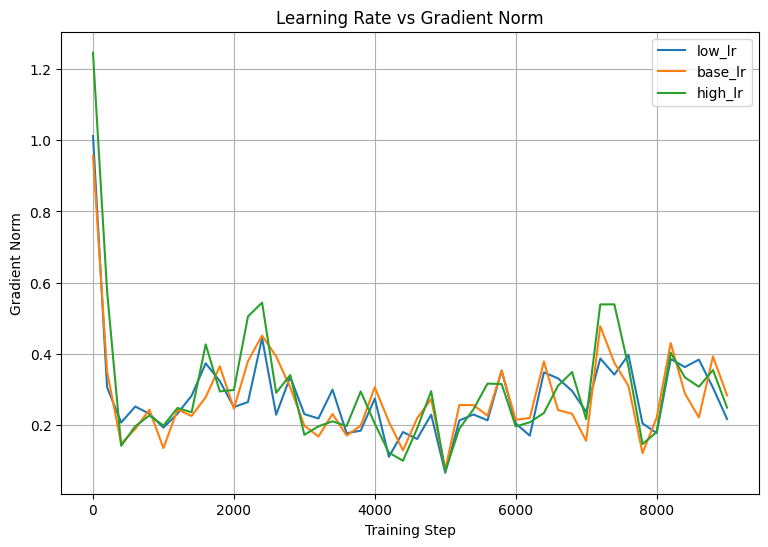

In [16]:
plt.figure(figsize=(9,6))

for run in processed:

    layer = list(processed[run].keys())[0]
    d = processed[run][layer]

    plt.plot(d["steps"], d["norms"], label=run)

plt.xlabel("Training Step")
plt.ylabel("Gradient Norm")
plt.title("Learning Rate vs Gradient Norm")
plt.legend()
plt.grid(True)
plt.show()


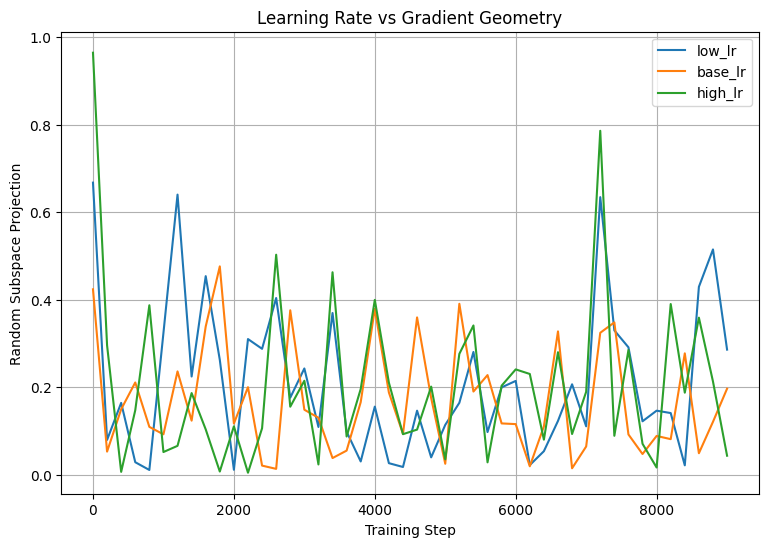

In [17]:
plt.figure(figsize=(9,6))

for run in processed:

    layer = list(processed[run].keys())[0]
    d = processed[run][layer]

    plt.plot(d["steps"], d["projs"], label=run)

plt.xlabel("Training Step")
plt.ylabel("Random Subspace Projection")
plt.title("Learning Rate vs Gradient Geometry")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
summary = {}

for run, data in processed.items():

    all_norms = []
    all_vars = []

    for layer in data.values():

        all_norms.extend(layer["norms"])
        all_vars.append(np.var(layer["projs"]))

    summary[run] = {
        "mean_norm": np.mean(all_norms),
        "proj_variance": np.mean(all_vars)
    }


for k,v in summary.items():

    print("\n", k.upper())
    print("Mean Grad Norm:", round(v["mean_norm"],4))
    print("Projection Variance:", round(v["proj_variance"],4))



 LOW_LR
Mean Grad Norm: 0.2739
Projection Variance: 0.083

 BASE_LR
Mean Grad Norm: 0.2459
Projection Variance: 0.0686

 HIGH_LR
Mean Grad Norm: 0.2262
Projection Variance: 0.0783


In [19]:
plt.savefig("figures/lr_norms.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [20]:
plt.savefig("figures/lr_geometry.png", dpi=300)


<Figure size 640x480 with 0 Axes>